In [251]:
import numpy as np
from qiskit import *
from qiskit.providers.ibmq import IBMQFactory
from qiskit.circuit.exceptions import CircuitError
from qiskit.compiler import transpile
from multiprocessing import Pool
from qiskit.transpiler.exceptions import TranspilerError
from qiskit.extensions import *
from qiskit.extensions.unitary import UnitaryGate
from scipy.linalg import schur
from qiskit import *
from qiskit.extensions import *
import numpy as np

from qiskit import BasicAer
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity
from qiskit.providers.aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.quantum_info import *
from typing import List
import os

from matplotlib import pyplot as plt
%matplotlib inline 
os.chdir('..')

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling2D, Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv1D, MaxPooling1D, UpSampling1D, concatenate
from tensorflow.keras.models import Model
from preproccessing_utils import circuit_to_tensor_with_u_gates, GateEnumerator, generate_concatenated_dataset
from typing import Tuple

In [9]:
dataset = np.load("circuit_tensor_dataset.npy")
target = np.load("circuit_tensor_dataset_y.npy")
target = target.astype(np.float32)

In [258]:
concat_dataset, y_diff = generate_concatenated_dataset(dataset, target)

In [259]:
X = concat_dataset.reshape((concat_dataset.shape[0] * concat_dataset.shape[1],) + concat_dataset.shape[2:])
y = y_diff.reshape((y_diff.shape[0] * y_diff.shape[1]))
X_norm = tf.keras.utils.normalize(X)

In [41]:
def simple_convnet2d(tensor_size, num_gates, num_channels):
    inputs = Input(shape=(tensor_size, num_gates, num_channels))
    conv1 = Conv2D(8, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=2, strides=(2,2))(conv1)
    conv2 = Conv2D(16, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=2, strides=(2,2))(conv2)

    dense_in = Flatten()(pool2)
    drop_in = Dropout(0.25)(dense_in)
    dense1 = Dense(10, activation='relu')(drop_in)
    dense3 = Dense(1)(dense1)

    model = Model(inputs=[inputs], outputs=[dense3])
    return model

In [50]:
model = simple_convnet2d(concat_dataset.shape[2], concat_dataset.shape[3], concat_dataset.shape[4])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [51]:
history = model.fit(X_norm, y, epochs=50, batch_size=128)

Epoch 1/50
125/125 [==============================] - 4s 28ms/step - loss: 0.0094 - mean_absolute_error: 0.0699
Epoch 2/50
125/125 [==============================] - 4s 32ms/step - loss: 0.0052 - mean_absolute_error: 0.0518
Epoch 3/50
125/125 [==============================] - 4s 32ms/step - loss: 0.0046 - mean_absolute_error: 0.0487
Epoch 4/50
125/125 [==============================] - 4s 34ms/step - loss: 0.0039 - mean_absolute_error: 0.0450
Epoch 5/50
125/125 [==============================] - 5s 37ms/step - loss: 0.0037 - mean_absolute_error: 0.0442
Epoch 6/50
125/125 [==============================] - 5s 38ms/step - loss: 0.0033 - mean_absolute_error: 0.0419
Epoch 7/50
125/125 [==============================] - 4s 33ms/step - loss: 0.0029 - mean_absolute_error: 0.0395
Epoch 8/50
125/125 [==============================] - 5s 38ms/step - loss: 0.0027 - mean_absolute_error: 0.0384
Epoch 9/50
125/125 [==============================] - 4s 33ms/step - loss: 0.0025 - mean_absolute_error:

In [64]:
y_pred = model.predict(X_norm)

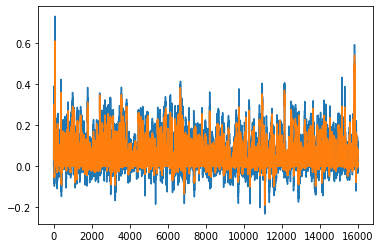

In [56]:
plt.plot(y)
plt.plot(y_pred)

In [30]:
# loss: 0.0014 - mean_absolute_error: 0.0273
# loss = MSE, optm = Adam, lr= 0.001, dropout = .1, no batch norm

In [221]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

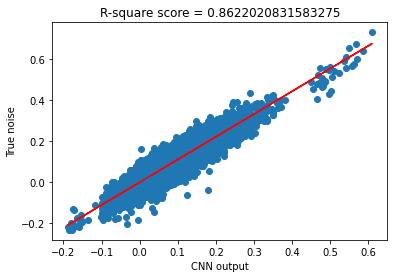

In [219]:
linreg = LinearRegression(fit_intercept=False)
obj = linreg.fit(y_pred, y)
trend_line = linreg.predict(y_pred)
plt.scatter(y_pred, y)
plt.plot(y_pred, trend_line, color='red')
plt.xlabel('CNN output')
plt.ylabel('True noise')
plt.title('R-square score = {}'.format(r2_score(y, y_pred)))
plt.show()
# y_pred explains 0.86% of the variance

In [210]:
# get the maximum difference in noise from each of the predictions
# if the noise of c0 is n(c_o), we want to maximize noise n(c_0) - n(ci).
# if n(ci) < n(c0) then n(c_0) - n(ci) > 0
y_hat = y_pred.reshape(y_diff.shape)
y_max_difference = np.argmax(y_hat, axis=1)

In [115]:
y_true = y.reshape(y_diff.shape)

In [216]:
# Ignore this step 
# best_circuits = y_true[np.arange(y_true.shape[0]), y_max_difference]

In [217]:
# We index the true variables with the 
# best circuit indices attained from y_pred
best_noise = target[np.arange(target.shape[0]), y_max_difference]

In [213]:
# The unmodified transpiller circuit is always at index 0
qasm_noise = target[np.arange(target.shape[0]), np.zeros(target.shape[0]).astype(np.int)]

In [214]:
# Average percentage of noise mitigated 
100 - ((np.mean(best_noise) / np.mean(qasm_noise)) * 100)

8.114749193191528

In [234]:
random_choice = np.random.randint(low=0, high=16, size=y_max_difference.shape[0])

In [238]:
# Taking a random guess
random_noise = target[np.arange(target.shape[0]), random_choice]

In [241]:
# Average noise
np.mean(best_noise), np.mean(qasm_noise), np.mean(random_noise)

(0.9061358, 0.9861602, 0.9259538)

In [252]:
np.var(best_noise), np.var(qasm_noise), np.var(random_noise)

(0.21495403, 0.2677426, 0.22457531)

In [277]:
# Generate the datasets for each folder
from sklearn.model_selection import KFold
num_folds = 5
kf = KFold(n_splits=5)
kf.get_n_splits(y)

folds_x_train, folds_x_test, folds_y_train, folds_y_test = [], [], [], []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    folds_x_train.append(X_train)
    folds_x_test.append(X_test)
    folds_y_train.append(y_train)
    folds_y_test.append(y_test)
    

In [276]:
# 5-fold cross-validation 
num_folds = 5
histories = []
for fold in range(num_folds):
    model = simple_convnet2d(concat_dataset.shape[2], concat_dataset.shape[3], concat_dataset.shape[4])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])
    history = model.fit(folds_x_train[fold], 
                        folds_y_train[fold],
                        epochs=50, 
                        batch_size=128,
                        validation_data=(folds_x_test[fold], folds_y_test[fold]))
    histories.append(history)
    

Epoch 1/50
100/100 [==============================] - 4s 38ms/step - loss: 0.0180 - mean_absolute_error: 0.0934 - val_loss: 0.0094 - val_mean_absolute_error: 0.0707
Epoch 2/50
100/100 [==============================] - 3s 33ms/step - loss: 0.0063 - mean_absolute_error: 0.0600 - val_loss: 0.0085 - val_mean_absolute_error: 0.0662
Epoch 3/50
100/100 [==============================] - 3s 35ms/step - loss: 0.0056 - mean_absolute_error: 0.0555 - val_loss: 0.0084 - val_mean_absolute_error: 0.0644
Epoch 4/50
100/100 [==============================] - 4s 37ms/step - loss: 0.0055 - mean_absolute_error: 0.0544 - val_loss: 0.0081 - val_mean_absolute_error: 0.0621
Epoch 5/50
100/100 [==============================] - 4s 37ms/step - loss: 0.0050 - mean_absolute_error: 0.0512 - val_loss: 0.0077 - val_mean_absolute_error: 0.0587
Epoch 6/50
100/100 [==============================] - 4s 37ms/step - loss: 0.0048 - mean_absolute_error: 0.0491 - val_loss: 0.0074 - val_mean_absolute_error: 0.0575
Epoch 7/50

100/100 [==============================] - 4s 39ms/step - loss: 0.0015 - mean_absolute_error: 0.0287 - val_loss: 0.0087 - val_mean_absolute_error: 0.0648
Epoch 1/50
100/100 [==============================] - 5s 43ms/step - loss: 0.0460 - mean_absolute_error: 0.1307 - val_loss: 0.0073 - val_mean_absolute_error: 0.0640
Epoch 2/50
100/100 [==============================] - 4s 40ms/step - loss: 0.0077 - mean_absolute_error: 0.0653 - val_loss: 0.0062 - val_mean_absolute_error: 0.0585
Epoch 3/50
100/100 [==============================] - 4s 39ms/step - loss: 0.0068 - mean_absolute_error: 0.0625 - val_loss: 0.0057 - val_mean_absolute_error: 0.0561
Epoch 4/50
100/100 [==============================] - 4s 39ms/step - loss: 0.0068 - mean_absolute_error: 0.0597 - val_loss: 0.0052 - val_mean_absolute_error: 0.0522
Epoch 5/50
100/100 [==============================] - 4s 40ms/step - loss: 0.0060 - mean_absolute_error: 0.0552 - val_loss: 0.0048 - val_mean_absolute_error: 0.0503
Epoch 6/50
100/100 [=

100/100 [==============================] - 4s 44ms/step - loss: 0.0021 - mean_absolute_error: 0.0341 - val_loss: 0.0052 - val_mean_absolute_error: 0.0539
Epoch 50/50
100/100 [==============================] - 4s 41ms/step - loss: 0.0021 - mean_absolute_error: 0.0339 - val_loss: 0.0051 - val_mean_absolute_error: 0.0535
Epoch 1/50
100/100 [==============================] - 5s 44ms/step - loss: 0.0295 - mean_absolute_error: 0.1180 - val_loss: 0.0055 - val_mean_absolute_error: 0.0555
Epoch 2/50
100/100 [==============================] - 4s 41ms/step - loss: 0.0074 - mean_absolute_error: 0.0617 - val_loss: 0.0047 - val_mean_absolute_error: 0.0510
Epoch 3/50
100/100 [==============================] - 4s 39ms/step - loss: 0.0065 - mean_absolute_error: 0.0585 - val_loss: 0.0044 - val_mean_absolute_error: 0.0491
Epoch 4/50
100/100 [==============================] - 4s 40ms/step - loss: 0.0057 - mean_absolute_error: 0.0536 - val_loss: 0.0043 - val_mean_absolute_error: 0.0472
Epoch 5/50
100/100 [

100/100 [==============================] - 4s 42ms/step - loss: 0.0018 - mean_absolute_error: 0.0313 - val_loss: 0.0052 - val_mean_absolute_error: 0.0529
Epoch 49/50
100/100 [==============================] - 4s 43ms/step - loss: 0.0018 - mean_absolute_error: 0.0317 - val_loss: 0.0052 - val_mean_absolute_error: 0.0526
Epoch 50/50
100/100 [==============================] - 4s 41ms/step - loss: 0.0018 - mean_absolute_error: 0.0315 - val_loss: 0.0051 - val_mean_absolute_error: 0.0525
Epoch 1/50
100/100 [==============================] - 5s 46ms/step - loss: 0.0414 - mean_absolute_error: 0.1239 - val_loss: 0.0072 - val_mean_absolute_error: 0.0647
Epoch 2/50
100/100 [==============================] - 4s 44ms/step - loss: 0.0076 - mean_absolute_error: 0.0661 - val_loss: 0.0068 - val_mean_absolute_error: 0.0640
Epoch 3/50
100/100 [==============================] - 4s 42ms/step - loss: 0.0067 - mean_absolute_error: 0.0625 - val_loss: 0.0064 - val_mean_absolute_error: 0.0610
Epoch 4/50
100/100 

100/100 [==============================] - 4s 44ms/step - loss: 0.0019 - mean_absolute_error: 0.0323 - val_loss: 0.0064 - val_mean_absolute_error: 0.0569
Epoch 48/50
100/100 [==============================] - 4s 40ms/step - loss: 0.0018 - mean_absolute_error: 0.0323 - val_loss: 0.0065 - val_mean_absolute_error: 0.0569
Epoch 49/50
100/100 [==============================] - 4s 39ms/step - loss: 0.0018 - mean_absolute_error: 0.0316 - val_loss: 0.0066 - val_mean_absolute_error: 0.0573
Epoch 50/50
100/100 [==============================] - 4s 40ms/step - loss: 0.0017 - mean_absolute_error: 0.0310 - val_loss: 0.0064 - val_mean_absolute_error: 0.0567
Epoch 1/50
100/100 [==============================] - 5s 38ms/step - loss: 0.0116 - mean_absolute_error: 0.0749 - val_loss: 0.0056 - val_mean_absolute_error: 0.0526
Epoch 2/50
100/100 [==============================] - 4s 39ms/step - loss: 0.0056 - mean_absolute_error: 0.0532 - val_loss: 0.0054 - val_mean_absolute_error: 0.0505
Epoch 3/50
100/100

100/100 [==============================] - 4s 39ms/step - loss: 0.0016 - mean_absolute_error: 0.0291 - val_loss: 0.0060 - val_mean_absolute_error: 0.0543
Epoch 47/50
100/100 [==============================] - 4s 39ms/step - loss: 0.0016 - mean_absolute_error: 0.0295 - val_loss: 0.0060 - val_mean_absolute_error: 0.0542
Epoch 48/50
100/100 [==============================] - 4s 40ms/step - loss: 0.0015 - mean_absolute_error: 0.0284 - val_loss: 0.0061 - val_mean_absolute_error: 0.0548
Epoch 49/50
100/100 [==============================] - 4s 39ms/step - loss: 0.0015 - mean_absolute_error: 0.0288 - val_loss: 0.0061 - val_mean_absolute_error: 0.0546
Epoch 50/50
100/100 [==============================] - 4s 38ms/step - loss: 0.0016 - mean_absolute_error: 0.0290 - val_loss: 0.0061 - val_mean_absolute_error: 0.0546


In [271]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error'])

In [286]:
fold_loss = [h.history['val_loss'][-1] for h in histories]
fold_mae = [h.history['val_mean_absolute_error'][-1] for h in histories]
fold_train_mae = [h.history['mean_absolute_error'][-1] for h in histories]

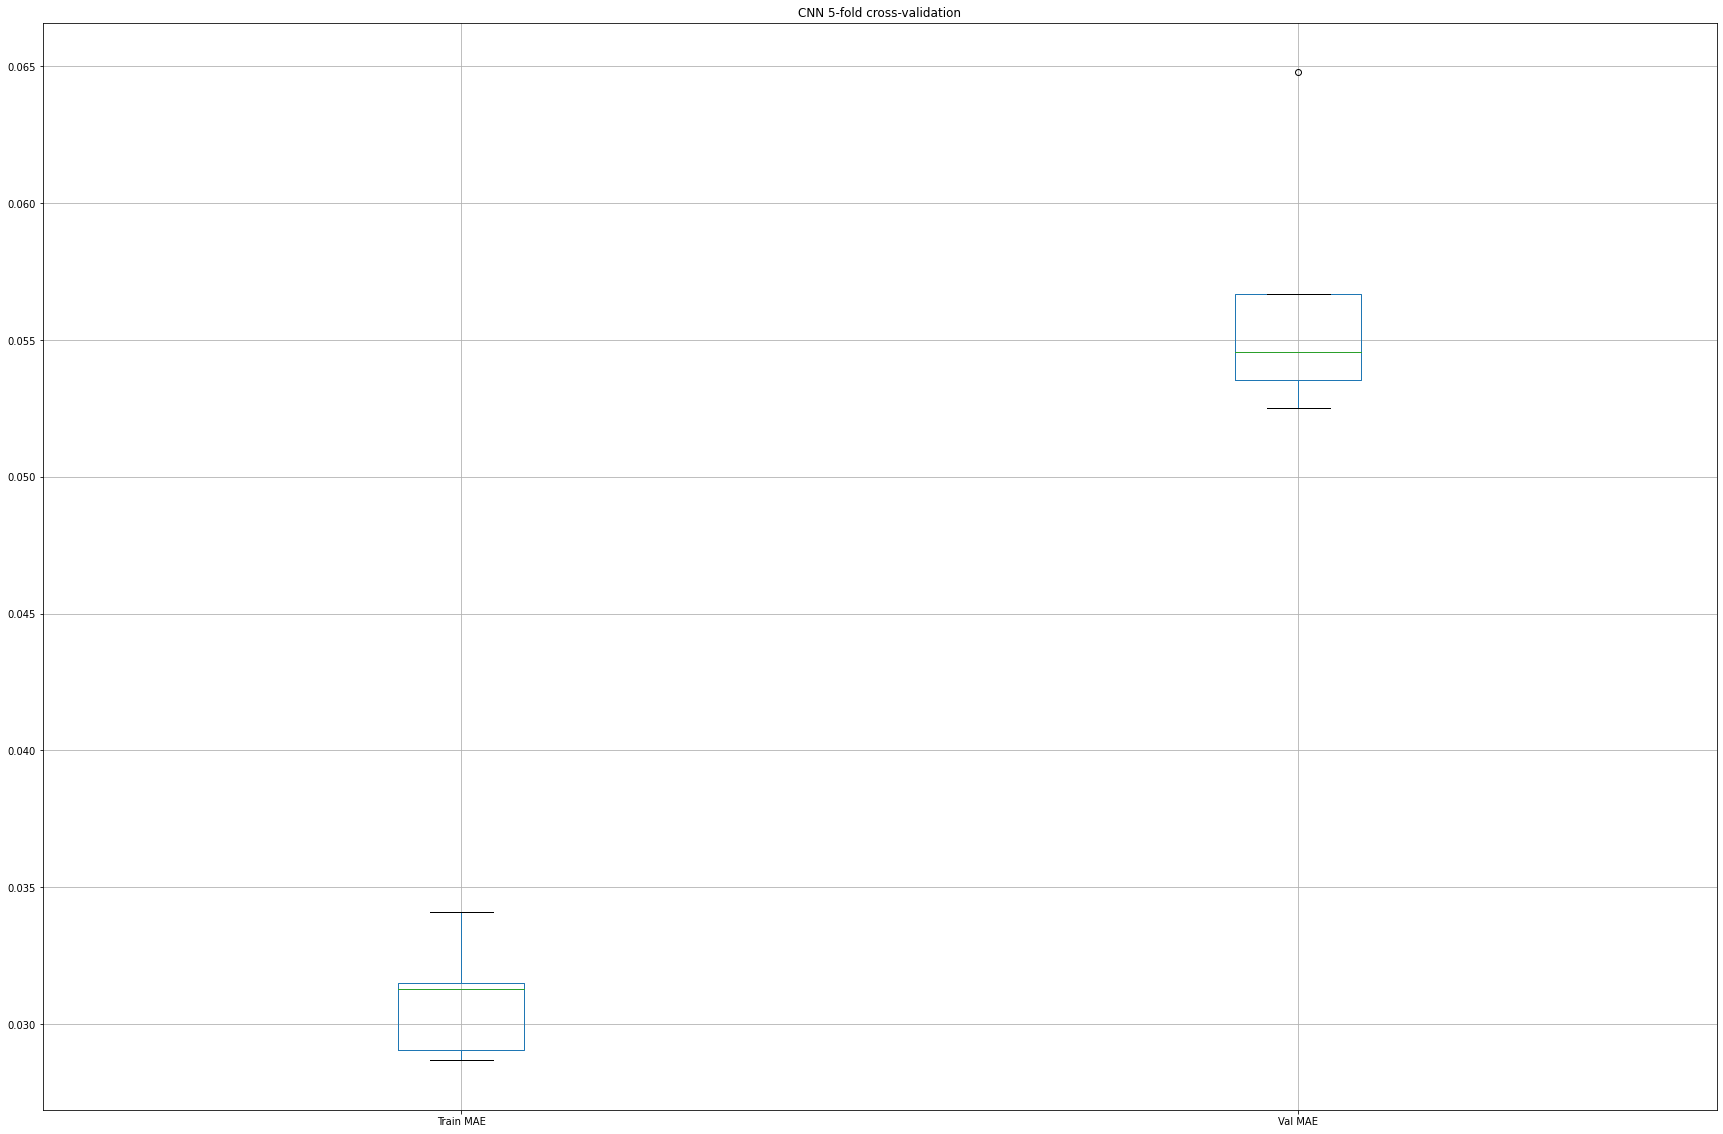

In [287]:
import pandas as pd
df = pd.DataFrame({"Train MAE":fold_train_mae,
                   "Val MAE": fold_mae})
boxplot = df.boxplot(column=list(df.keys()),
                    figsize=(30, 20))

title_boxplot = 'CNN 5-fold cross-validation'

plt.title(title_boxplot)
plt.show()

In [282]:
histories[0].history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])